# CVX 2021-2022 Project 5 

In [1]:
# Import packages.
# free SDP solver: https://github.com/TrishGillett/pysdpt3glue
import cvxpy as cp
import numpy as np
from numpy.linalg import matrix_power
from numpy import linalg as LA
# make sure to use np.zeros() when you need something to initialize at 0. 

In [2]:
# The given data contains for E trajectories (different initial conditions) the vector x_{K+1}.
# load that data
data = np.loadtxt("datax.txt")

# Define the dynamics
Adyn = np.matrix([[0.5, 0.8], [0, 0.5]])
n = 2
Q0 = np.matrix([[1, 0], [0, 1]])
Qw = np.matrix([[1, 0], [0, 1]])

In [3]:
data.shape

(2, 1000)

## Empirical probability

In [4]:
def compute_e(Q0, Qw, Adyn, k):
    E_p = np.zeros(Q0.shape)
    for i in range(k + 1):
        mat_temp = matrix_power(Adyn, (k-i))
        E_p += mat_temp @ Qw @ mat_temp.T
        
    return matrix_power(Adyn, k) @ Q0 @ (matrix_power(Adyn, k)).T + E_p

In [5]:
# Compute the first two moments 
K = 10
E_pk = np.zeros((2,1))
E_pkkT = compute_e(Q0, Qw, Adyn, K + 1)

In [6]:
# compute the empirical probability of being in the safe set 
E = 1000
saft_range = 8

real_norm = np.linalg.norm(data, axis = 0, ord=1)
emp_prob = (real_norm < saft_range).sum() / E
print('Empirical probability: {:.2f}%'.format(emp_prob*100))

Empirical probability: 99.80%


## SDP Solution

In [7]:
b = 1 / 2 * np.array([[1.0, 1], [1, -1], [-1, 1], [-1, -1]])

c = np.array([-saft_range, -saft_range, -saft_range, -saft_range])

P = cp.Variable((n, n), symmetric=True)
q = cp.Variable((n, 1))
r = cp.Variable((1, 1))
m = 4
tau = cp.Variable((m, 1))


obj = 1 - cp.trace(E_pkkT @ P) - 2 * (q.T @ E_pk) - r

constr = []

for i in range(m):
    constr.append(
        cp.bmat(
            [[P, q - tau[i] * np.atleast_2d(b[i]).T],
             [(q - tau[i] * np.atleast_2d(b[i]).T).T, (r - 1 - tau[i] * c[i])]]
        ) >> 0
    )

constr.append(cp.bmat([[P, q], [q.T, r]]) >> 0)

constr.append(tau >= 0)

prob = cp.Problem(cp.Maximize(obj), constr)
prob.solve()

print("Worst-case probability from SDP: {:.2f}%".format(prob.value * 100))

Worst-case probability from SDP: 86.39%


## Multiple iterations 

In [8]:
res = []
for idx in range(0, 21):
    E_pkkT = compute_e(Q0, Qw, Adyn, idx + 1)
    b = 1 / 2 * np.array([[1.0, 1], [1, -1], [-1, 1], [-1, -1]])

    c = np.array([-saft_range, -saft_range, -saft_range, -saft_range])

    P = cp.Variable((n, n), symmetric=True)
    q = cp.Variable((n, 1))
    r = cp.Variable((1, 1))
    m = 4
    tau = cp.Variable((m, 1))


    obj = 1 - cp.trace(E_pkkT @ P) - 2 * (q.T @ E_pk) - r

    constr = []

    for i in range(m):
        constr.append(
            cp.bmat(
                [[P, q - tau[i] * np.atleast_2d(b[i]).T],
                 [(q - tau[i] * np.atleast_2d(b[i]).T).T, (r - 1 - tau[i] * c[i])]]
            ) >> 0
        )

    constr.append(cp.bmat([[P, q], [q.T, r]]) >> 0)

    constr.append(tau >= 0)

    prob = cp.Problem(cp.Maximize(obj), constr)
    prob.solve()

    res.append(prob.value)
    print("Worst-case probability after {} step: {:.4f}%".format(idx, prob.value * 100))

Worst-case probability after 0 step: 86.9311%
Worst-case probability after 1 step: 86.0515%
Worst-case probability after 2 step: 86.0517%
Worst-case probability after 3 step: 86.2053%
Worst-case probability after 4 step: 86.3077%
Worst-case probability after 5 step: 86.3558%
Worst-case probability after 6 step: 86.3750%
Worst-case probability after 7 step: 86.3820%
Worst-case probability after 8 step: 86.3844%
Worst-case probability after 9 step: 86.3852%
Worst-case probability after 10 step: 86.3855%
Worst-case probability after 11 step: 86.3855%
Worst-case probability after 12 step: 86.3856%
Worst-case probability after 13 step: 86.3856%
Worst-case probability after 14 step: 86.3856%
Worst-case probability after 15 step: 86.3856%
Worst-case probability after 16 step: 86.3856%
Worst-case probability after 17 step: 86.3856%
Worst-case probability after 18 step: 86.3856%
Worst-case probability after 19 step: 86.3856%
Worst-case probability after 20 step: 86.3856%


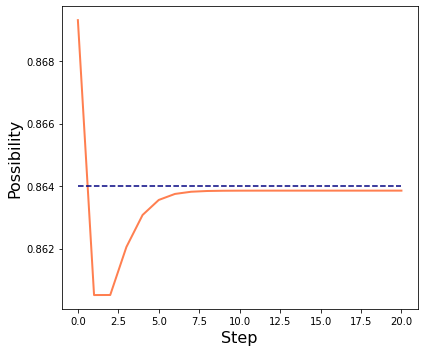

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(res, color="coral", linewidth=2)
ax.set_xlabel("Step", fontsize=16)
ax.set_ylabel("Possibility", fontsize=16)
ax.plot((0.0, 20), (0.864, 0.864), linestyle="--", color="navy")
fig.tight_layout()
plt.savefig("possibility_by_step.pdf", dpi=300)

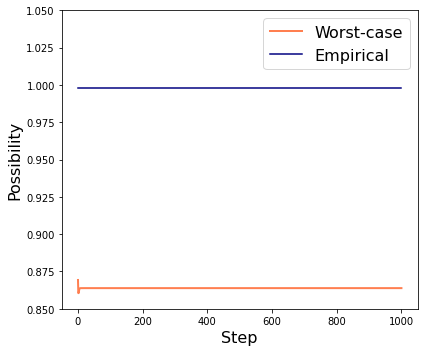

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(res+980*[0.863856], color="coral", linewidth=2, label='Worst-case')
ax.set_xlabel("Step", fontsize=16)
ax.set_ylabel("Possibility", fontsize=16)
ax.plot((0.0, 1000), (0.9980, 0.9980), linestyle="-", color="navy", label='Empirical')
ax.legend(fontsize=16)
ax.set_ylim(bottom=0.85, top=1.05)
fig.tight_layout()
plt.savefig("possibility_by_step_comp.pdf", dpi=300)